In [1]:
from tqdm import tqdm
import pandas as pd
from sigmulib import compute_sigmul_cpp, compute_sigmul_cython
import numpy as np

from utils import *

In [2]:
A = torch.normal(0, 1, (2, 2))

In [3]:
compute_sigmul_cpp(A.tolist())

[[0.8709138035774231, -0.06582366675138474],
 [0.2923249304294586, 0.04571608081459999]]

In [4]:
sigmul_torch(A)

tensor([[ 0.8709, -0.0658],
        [ 0.2923,  0.0457]])

In [7]:
compute_sigmul_cython(np.asarray(A, dtype=np.float32))

array([[ 0.8709138 , -0.06582367],
       [ 0.29232493,  0.04571608]], dtype=float32)

In [9]:
dims = [2**i for i in range(14)]
# all_times = pd.DataFrame(index=dims, columns=['list', 'tensor_1', 'tensor_2', 'tensor_3', 'torch'])
# diffs = pd.DataFrame(index=dims, columns=['list', 'tensor_1', 'tensor_2'])
all_times = pd.DataFrame(index=dims, columns=['sigmul_cpp', 'sigmul_cython', 'sigmul_torch'])
diffs = pd.DataFrame(index=dims, columns=['sigmul_cpp', 'sigmul_cython'])

for dim in tqdm(dims):
    A = torch.normal(0, 1, (dim, dim))

    times = compare_times(A, n_rep=10)
    for key in times.keys():
        all_times.loc[dim, key] = times[key]

    Bt = sigmul_torch(A)
    diffs.loc[dim, 'sigmul_cpp'] = torch.abs(Bt - torch.tensor(compute_sigmul_cpp(A.tolist()))).sum().item() / (dim**2)
    diffs.loc[dim, 'sigmul_cython'] = torch.abs(Bt - torch.tensor(compute_sigmul_cython(np.asarray(A, dtype=np.float32)))).sum().item() / (dim**2)
    # diffs.loc[dim, 'tensor_1'] = torch.abs(Bt - torch.tensor(compute_sigmul(A))).sum().item()
    # diffs.loc[dim, 'tensor_2'] = torch.abs(Bt - sigmul_from_tensor(A)).sum().item()


100%|██████████| 14/14 [02:14<00:00,  9.61s/it]


In [10]:
all_times

,sigmul_cpp,sigmul_cython,sigmul_torch
1,0.060854,0.128163,0.000052
2,0.061761,0.119646,0.000027
4,0.066633,0.121477,0.000077
8,0.060953,0.126897,0.000037
16,0.060093,0.121496,0.000041
32,0.062275,0.127692,0.000065
64,0.063338,0.137126,0.000034
128,0.061272,0.126851,0.000134
256,0.06219,0.136574,0.003794
512,0.070709,0.126796,0.003508


<Axes: >

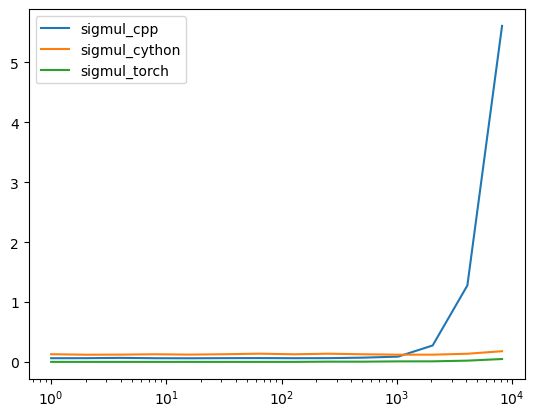

In [12]:
all_times.plot(logx=True)

<Axes: >

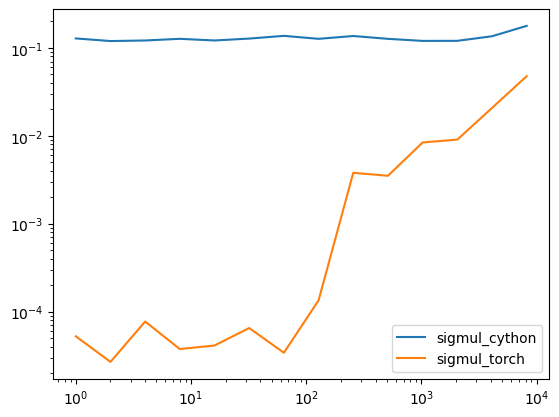

In [16]:
all_times[['sigmul_cython', 'sigmul_torch']].plot(logx=True, logy=True)

<Axes: >

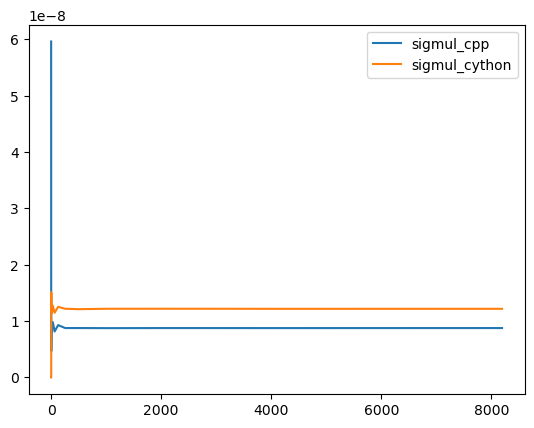

In [13]:
diffs.plot()

In [2]:
dims = [2**i for i in range(16)]
all_times = pd.DataFrame(index=dims, columns=['sigmul_cython', 'sigmul_torch'])
diffs = pd.DataFrame(index=dims, columns=['sigmul_cython'])

for dim in tqdm(dims):
    A = torch.normal(0, 1, (dim, dim))

    times = compare_times(A, n_rep=10, include_cpp=False)
    for key in times.keys():
        all_times.loc[dim, key] = times[key]

    Bt = sigmul_torch(A)
    diffs.loc[dim, 'sigmul_cython'] = torch.abs(Bt - torch.tensor(compute_sigmul_cython(np.asarray(A, dtype=np.float32)))).sum().item() / (dim**2)


100%|██████████| 16/16 [00:50<00:00,  3.18s/it]


<Axes: >

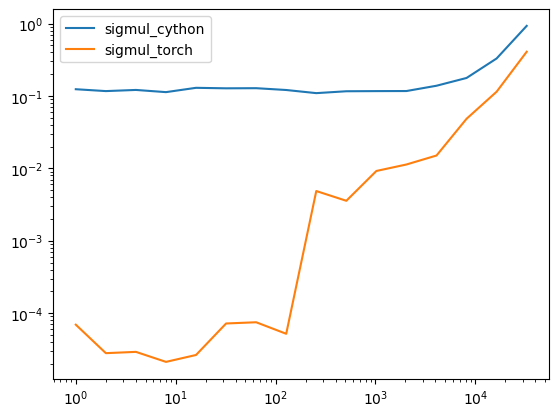

In [4]:
all_times.plot(logx=True, logy=True)

In [6]:
all_times['ratio'] = all_times['sigmul_cython'] / all_times['sigmul_torch']

In [7]:
all_times

,sigmul_cython,sigmul_torch,ratio
1,0.124043,0.000069,1793.436057
2,0.116872,0.000028,4182.547782
4,0.121231,0.000029,4164.456183
8,0.113082,0.000021,5341.239865
16,0.129715,0.000026,4919.192586
32,0.12767,0.000072,1777.2539
64,0.128175,0.000075,1715.941909
128,0.121006,0.000052,2337.803316
256,0.109513,0.00486,22.534273
512,0.116273,0.003563,32.632055


<Axes: >

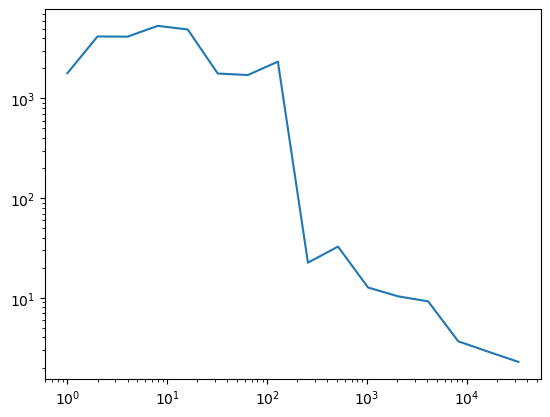

In [11]:
all_times['ratio'].plot(logx=True, logy=True)

<Axes: >

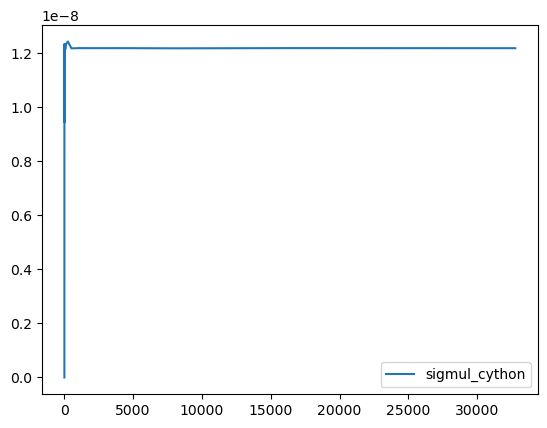

In [8]:
diffs.plot()